## Feature Engineering with PySpark.
This tutorial uses the output files generated in the EDA script

The code is copied from the video: https://www.youtube.com/watch?v=TlXqsL4ysB0&t=178s

In [1]:
from pyspark.sql import SparkSession, Window
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier

In [2]:
spark = (
    SparkSession.builder.appName("iot")
    .master("local[*]")
    .config("spark.driver.host", "localhost")
    .config("spark.driver.bindAddress", "127.0.0.1")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)
spark.sparkContext.setLogLevel("ERROR")

In [3]:
output_dir = r"C:\Users\gabyl\spark_outputs\preprocessing"

df = spark.read.parquet(output_dir)
df.show()

+-------------------+------------------+---------------+-----------+--------------+---------+-----+-------+---------+----------+----------+----------+--------+---------+-------------+---------+-------------+---------+--------------------+-------------------+-------------------+-------------------+-------------------+------+-----------------------+------------------------+-------------------------+--------------------------+---------------------+----------------------+-----------------------+------------------------+--------------------------+---------------------------+---------------------------+----------+
|                 ts|               uid|      source_ip|source_port|       dest_ip|dest_port|proto|service| duration|orig_bytes|resp_bytes|conn_state| history|orig_pkts|orig_ip_bytes|resp_pkts|resp_ip_bytes|    label|      detailed-label|                 dt|               hour|             minute|             second|is_bad|source_ip_count_last_5m|source_ip_count_last_30m|source_por

In [4]:
def get_path_size_bytes(spark, path):
    """
    Calculates the total size of a directory in bytes using Hadoop FileSystem API.

    :param spark: The SparkSession object.
    :param path: The path to the data (e.g., "s3a://my-bucket/my-data/" or "/path/to/data").
    :return: Total size in bytes (long).
    """
    sc = spark.sparkContext
    # Get the Hadoop FileSystem object
    fs = sc._jvm.org.apache.hadoop.fs.FileSystem.get(
        sc._jvm.java.net.URI.create(path), 
        sc._jsc.hadoopConfiguration()
    )
    # Get the content summary of the path, which includes the total size
    summary = fs.getContentSummary(sc._jvm.org.apache.hadoop.fs.Path(path))
    return summary.getLength()

total_size_bytes = get_path_size_bytes(spark, '/Users/gabyl/spark_outputs/preprocessing')

# You can convert bytes to a more readable format
total_size_gb = total_size_bytes / (1024**3)

print(f"Total data size on disk: {total_size_bytes} bytes")
print(f"Total data size on disk: {total_size_gb:.2f} GB")

# Assuming 'df' is your DataFrame
total_rows = df.count()

print(f"Total number of rows: {total_rows}")

Total data size on disk: 77312669 bytes
Total data size on disk: 0.07 GB
Total number of rows: 1008748


In [5]:
df = df.withColumn("is_bad", F.when(F.col("label") != "Benign", 1).otherwise(0))

## Feature Engineering
Let's add some time-series features

In [6]:
# Example of rolling feature generation
df.withColumn(
    "activity_count_last_5m",
    F.count('source_ip').over(Window().partitionBy('source_ip').orderBy(F.col('dt').cast('long')).rangeBetween(-5*60,-1))
).show()

+-------------------+------------------+---------------+-----------+---------------+---------+-----+-------+---------+----------+----------+----------+-------+---------+-------------+---------+-------------+------+--------------+-------------------+-------------------+-------------------+-------------------+------+-----------------------+------------------------+-------------------------+--------------------------+---------------------+----------------------+-----------------------+------------------------+--------------------------+---------------------------+---------------------------+----------+----------------------+
|                 ts|               uid|      source_ip|source_port|        dest_ip|dest_port|proto|service| duration|orig_bytes|resp_bytes|conn_state|history|orig_pkts|orig_ip_bytes|resp_pkts|resp_ip_bytes| label|detailed-label|                 dt|               hour|             minute|             second|is_bad|source_ip_count_last_5m|source_ip_count_last_30m|sourc

In [7]:
# Lets create some custom functions
def create_custom_window(
    partition_by: str,
    timestamp_col: str,
    window_in_minutes: int,
):
    window = (
        Window()
        .partitionBy(partition_by)
        .orderBy(F.col(timestamp_col).cast('long'))
        .rangeBetween(-window_in_minutes*60, -1)
    )
    
    return window

def generate_rolling_aggregate(
    col: str,
    partition_by: str = None,
    operation: str = "count",
    timestamp_col: str = "dt",
    window_in_minutes: int = 1,
):
    if partition_by is None:
        partition_by = col
    
    if operation == "count":
        return F.count(col).over(
            create_custom_window(
                partition_by=partition_by,
                timestamp_col=timestamp_col,
                window_in_minutes=window_in_minutes
            )
        )
    elif operation == "sum":
        return F.sum(col).over(
            create_custom_window(
                partition_by=partition_by,
                timestamp_col=timestamp_col,
                window_in_minutes=window_in_minutes
            )
        )
    elif operation == "avg":
        return F.avg(col).over(
            create_custom_window(
                partition_by=partition_by,
                timestamp_col=timestamp_col,
                window_in_minutes=window_in_minutes
            )
        )
    else:
        raise ValueError(f"Operation '{operation}' is not defined.")

In [8]:
# Now we apply the custom feature engineering to create several new features.
# This cell won't take any time because it doesn't really apply to the dataframe. It just defines the calculations to take place.
# We'de need to apply a df.show() for example for it to really compute
df = df.withColumns({
    "source_ip_count_last_5m" : generate_rolling_aggregate(col='source_ip', partition_by='source_ip', operation='count', window_in_minutes=5),
    "source_ip_count_last_30m" : generate_rolling_aggregate(col='source_ip', partition_by='source_ip', operation='count', window_in_minutes=30),
    "source_port_count_last_5m" : generate_rolling_aggregate(col='source_port', partition_by='source_port', operation='count', window_in_minutes=5),
    "source_port_count_last_30m" : generate_rolling_aggregate(col='source_port', partition_by='source_port', operation='count', window_in_minutes=30),
    "dest_ip_count_last_5m" : generate_rolling_aggregate(col='dest_ip', partition_by='dest_ip', operation='count', window_in_minutes=5),
    "dest_ip_count_last_30m" : generate_rolling_aggregate(col='dest_ip', partition_by='dest_ip', operation='count', window_in_minutes=30),
    "dest_port_count_last_5m" : generate_rolling_aggregate(col='dest_port', partition_by='dest_port', operation='count', window_in_minutes=5),
    "dest_port_count_last_30m" : generate_rolling_aggregate(col='dest_port', partition_by='dest_port', operation='count', window_in_minutes=30),
    "source_ip_avg_pkts_last_5m": generate_rolling_aggregate(col='orig_pkts', partition_by='source_ip', operation='avg', window_in_minutes=5),
    "source_ip_avg_pkts_last_30m": generate_rolling_aggregate(col='orig_pkts', partition_by='source_ip', operation='avg', window_in_minutes=30),
    "source_ip_avg_bytes_last_5m": generate_rolling_aggregate(col='orig_ip_bytes', partition_by='source_ip', operation='avg', window_in_minutes=5),
    "source_ip_avg_pkts_last_30m": generate_rolling_aggregate(col='orig_ip_bytes', partition_by='source_ip', operation='avg', window_in_minutes=30),
})

In [9]:
output_dir_fe = r"C:\Users\gabyl\spark_outputs\feature_engineering"

df.write.mode('overwrite').partitionBy("day").parquet(output_dir)

In [10]:
df_feat_eng = spark.read.parquet(output_dir)
del df
df_feat_eng.show()

+-------------------+------------------+---------------+-----------+--------------+---------+-----+-------+---------+----------+----------+----------+--------+---------+-------------+---------+-------------+---------+--------------------+-------------------+-------------------+-------------------+-------------------+------+-----------------------+------------------------+-------------------------+--------------------------+---------------------+----------------------+-----------------------+------------------------+--------------------------+---------------------------+---------------------------+----------+
|                 ts|               uid|      source_ip|source_port|       dest_ip|dest_port|proto|service| duration|orig_bytes|resp_bytes|conn_state| history|orig_pkts|orig_ip_bytes|resp_pkts|resp_ip_bytes|    label|      detailed-label|                 dt|               hour|             minute|             second|is_bad|source_ip_count_last_5m|source_ip_count_last_30m|source_por

In [11]:
df_feat_eng.dtypes

[('ts', 'double'),
 ('uid', 'string'),
 ('source_ip', 'string'),
 ('source_port', 'double'),
 ('dest_ip', 'string'),
 ('dest_port', 'double'),
 ('proto', 'string'),
 ('service', 'string'),
 ('duration', 'double'),
 ('orig_bytes', 'double'),
 ('resp_bytes', 'double'),
 ('conn_state', 'string'),
 ('history', 'string'),
 ('orig_pkts', 'double'),
 ('orig_ip_bytes', 'double'),
 ('resp_pkts', 'double'),
 ('resp_ip_bytes', 'double'),
 ('label', 'string'),
 ('detailed-label', 'string'),
 ('dt', 'timestamp'),
 ('hour', 'timestamp'),
 ('minute', 'timestamp'),
 ('second', 'timestamp'),
 ('is_bad', 'int'),
 ('source_ip_count_last_5m', 'bigint'),
 ('source_ip_count_last_30m', 'bigint'),
 ('source_port_count_last_5m', 'bigint'),
 ('source_port_count_last_30m', 'bigint'),
 ('dest_ip_count_last_5m', 'bigint'),
 ('dest_ip_count_last_30m', 'bigint'),
 ('dest_port_count_last_5m', 'bigint'),
 ('dest_port_count_last_30m', 'bigint'),
 ('source_ip_avg_pkts_last_5m', 'double'),
 ('source_ip_avg_pkts_last_30m'

In [12]:
# Selecting the numerical and categorical feature names
numerical_cols = []
categorical_cols = []
for col, dtype in df_feat_eng.dtypes:
    if col in ['ts','spurce_port','dest_port','is_bad']:
        continue
    if dtype in ['int', 'bigint', 'float', 'double', 'decimal']:
        numerical_cols.append(col)
    elif dtype == 'string':
        categorical_cols.append(col)
print(numerical_cols, categorical_cols)

['source_port', 'duration', 'orig_bytes', 'resp_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'source_ip_count_last_5m', 'source_ip_count_last_30m', 'source_port_count_last_5m', 'source_port_count_last_30m', 'dest_ip_count_last_5m', 'dest_ip_count_last_30m', 'dest_port_count_last_5m', 'dest_port_count_last_30m', 'source_ip_avg_pkts_last_5m', 'source_ip_avg_pkts_last_30m', 'source_ip_avg_bytes_last_5m'] ['uid', 'source_ip', 'dest_ip', 'proto', 'service', 'conn_state', 'history', 'label', 'detailed-label']


In [13]:
# Lets see what features have a small amount of unique values, because we don't want to process one-hot encode really long unique values
df_feat_eng.select([F.count_distinct(col) for col in categorical_cols]).show()

+-------------------+-------------------------+-----------------------+---------------------+-----------------------+--------------------------+-----------------------+---------------------+------------------------------+
|count(DISTINCT uid)|count(DISTINCT source_ip)|count(DISTINCT dest_ip)|count(DISTINCT proto)|count(DISTINCT service)|count(DISTINCT conn_state)|count(DISTINCT history)|count(DISTINCT label)|count(DISTINCT detailed-label)|
+-------------------+-------------------------+-----------------------+---------------------+-----------------------+--------------------------+-----------------------+---------------------+------------------------------+
|            1008748|                    15004|                 597107|                    3|                      5|                        11|                    126|                    2|                             2|
+-------------------+-------------------------+-----------------------+---------------------+-------------------

In [14]:
# Lets apply some innitial filering:
categorical_cols_to_drop = ['uid','source_ip','dest_ip','label', 'detailed-label']
categorical_cols = [col for col in categorical_cols if col not in categorical_cols_to_drop]

In [15]:
# Maybe we can reduce the number of unique values in each feature by filtering out the least frequent ones:
categorical_valid_values = {}
for col in categorical_cols:
    # Save all the classes that appear more than 100 times
    categorical_valid_values[col] = (
        df_feat_eng.groupby(col)
        .count()
        .filter(F.col("count") > 100)
        .select(col)
        .toPandas()
        .values.ravel()
    )
    
    # Transform all the classes that are NOT in the previous saved classes, to the class: 'Other'
    df_feat_eng = df_feat_eng.withColumn(
        col,
        F.when(F.col(col).isin(list(categorical_valid_values[col])), F.col(col)).otherwise(
            F.lit("Other").alias(col)
        )
    )

In [16]:
# Read again the count of classes in each feature, to see the effect of the previous transformation
df_feat_eng.select([F.count_distinct(col) for col in categorical_cols]).show()

+---------------------+-----------------------+--------------------------+-----------------------+
|count(DISTINCT proto)|count(DISTINCT service)|count(DISTINCT conn_state)|count(DISTINCT history)|
+---------------------+-----------------------+--------------------------+-----------------------+
|                    3|                      3|                         7|                     22|
+---------------------+-----------------------+--------------------------+-----------------------+



## Train-Test Split
We could do something like: df.randomSplit() But we want to need to split it by source IP adress to avoid data leakage

In [17]:
# Lets see the counts of malicious data for every source_ip in descending order
df_feat_eng.groupby("source_ip").agg(F.sum(F.col("is_bad")).alias("bad_sum")).orderBy("bad_sum", ascending=False).show(5)

+---------------+-------+
|      source_ip|bad_sum|
+---------------+-------+
|192.168.100.103| 539473|
|  219.250.49.64|      0|
|109.239.172.131|      0|
| 119.67.116.218|      0|
| 27.158.202.208|      0|
+---------------+-------+
only showing top 5 rows


In [18]:
# Training non-malicious IPs on 80%
train_ips = (
    df_feat_eng.where(
        ~F.col('source_ip').isin(['192.168.100.103'])
    )
    .select(F.col('source_ip'), F.lit(1).alias("is_train"))
    .dropDuplicates()
    .sample(0.8)
)

df_feat_eng = df_feat_eng.join(train_ips, on="source_ip", how="left")

In [19]:
# We need to create the training and testing dataframes. We only have malicious data on the Source IP 192.168.100.103 (apparently)
# How can we separate the train and test dataframes so that both have an equal balance of malicious and non-malicious classes?
# We have to ensure we avoid data leakage by placing the same ip_address on both training and testing dataframes

In [20]:
malicious_ip_df = df_feat_eng.where(F.col("source_ip") == '192.168.100.103')
benign_ip_df = df_feat_eng.where(F.col("source_ip") != '192.168.100.103')

# Now split each df 20/80 for test/train
malicious_train_df, malicious_test_df = malicious_ip_df.randomSplit([0.8, 0.2], seed=42)
benign_train_df, benign_test_df = benign_ip_df.randomSplit([0.8, 0.2], seed=42)

# Now join the 
train_df = malicious_train_df.unionByName(benign_train_df)
test_df = malicious_test_df.unionByName(benign_test_df)

print("Training Data Distribution:")
train_df.groupBy('label').count().show()

print("Testing Data Distribution:")
test_df.groupBy('label').count().show()

Training Data Distribution:
+---------+------+
|    label| count|
+---------+------+
|Malicious|431813|
|   Benign|375618|
+---------+------+

Testing Data Distribution:
+---------+------+
|    label| count|
+---------+------+
|Malicious|107660|
|   Benign| 93657|
+---------+------+



## Machine Learning Pipeline

In [21]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier

In [22]:
categorical_cols_indexed = [col + '_index' for col in categorical_cols]
input_features = numerical_cols + categorical_cols_indexed

# Label encode for the categorical features
ind = StringIndexer(inputCols=categorical_cols, outputCols=categorical_cols_indexed, handleInvalid='skip')
# Spark operates ML on vectors. VectorAssemblers transforms all features into vectors for the ML engine
va = VectorAssembler(inputCols=input_features, outputCol='features', handleInvalid='skip')
# Just a Random Forest Classifier
rf = RandomForestClassifier(featuresCol='features', labelCol='is_bad', numTrees=100)

pipeline = Pipeline(stages=[ind, va, rf])

In [23]:
pipeline = pipeline.fit(train_df)
test_preds = pipeline.transform(test_df)

In [24]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

roc = BinaryClassificationEvaluator(labelCol='is_bad', metricName='areaUnderROC')
print('ROC AUC', roc.evaluate(test_preds))

pr = BinaryClassificationEvaluator(labelCol='is_bad', metricName='areaUnderPR')
print('PR AUC', pr.evaluate(test_preds))

ROC AUC 0.9999976674519848
PR AUC 0.9999983822848577


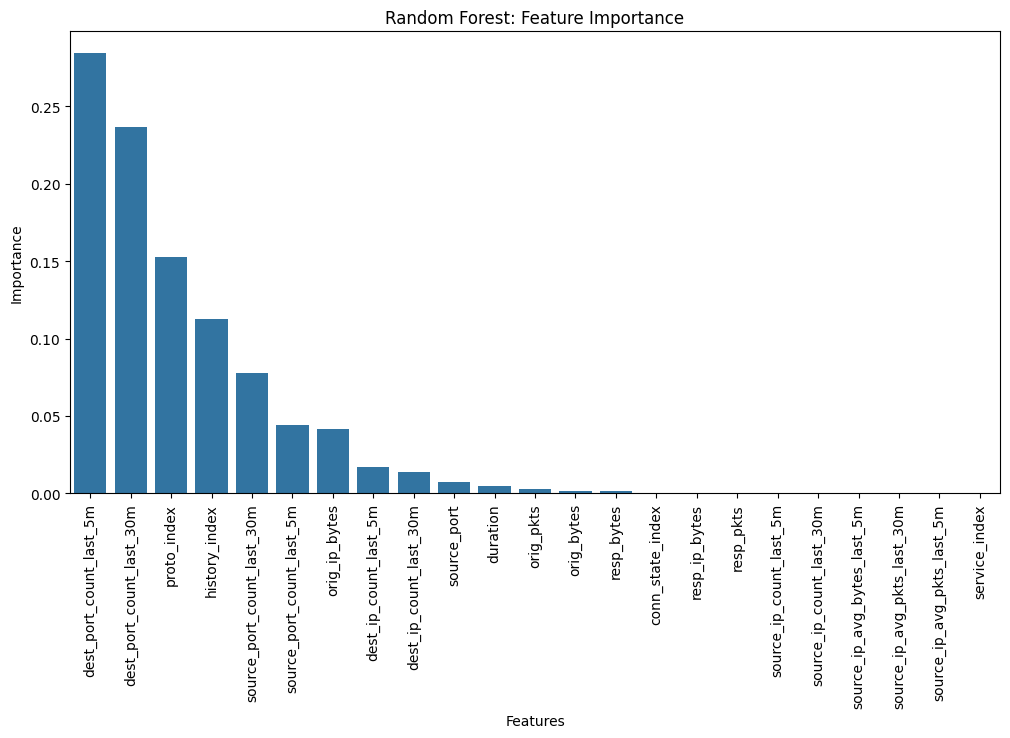

In [35]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

df_feature_importance = pd.DataFrame(
    {
        'Importance' : pipeline.stages[-1].featureImportances.values,
        'Features' : pipeline.stages[-2].getInputCols(),
    }
).sort_values("Importance", ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(data=df_feature_importance,
            x='Features',
            y='Importance')
plt.title('Random Forest: Feature Importance')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Lets see the distribution for the most important feature. We can see its average value in both dataframes is similar for malicious and benign records
train_df.groupby('is_bad').agg(F.avg('dest_port_count_last_5m')).show()
test_df.groupby('is_bad').agg(F.avg('dest_port_count_last_5m')).show()

+------+----------------------------+
|is_bad|avg(dest_port_count_last_5m)|
+------+----------------------------+
|     1|          142.34379696766888|
|     0|         0.45565973941610893|
+------+----------------------------+

+------+----------------------------+
|is_bad|avg(dest_port_count_last_5m)|
+------+----------------------------+
|     1|           142.7863366152703|
|     0|          0.4497368055777998|
+------+----------------------------+

